In [1]:
import utils

import os
import pickle

import matplotlib.pyplot as plt
%matplotlib inline 

In [6]:
F_toLoad = [('A1',4), 
            ('A2',4),
           ]

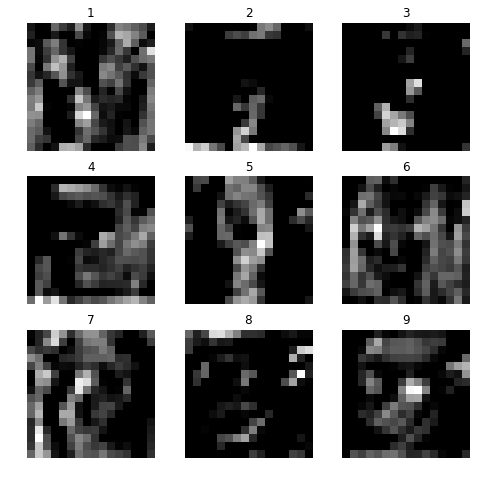

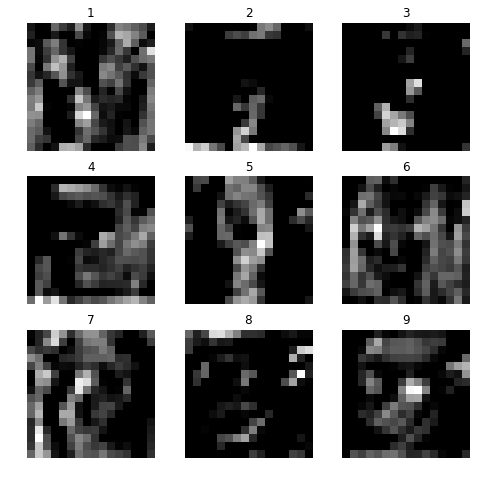

In [7]:
for (F_i, L_i) in F_toLoad:
    F = utils.loadFeatureMaps(os.path.join('featureMaps_' + F_i + '.pkl'))

    plt.figure(figsize=(8, 8))
    for f in range(9):
        plt.subplot(3,3,f+1)
        plt.imshow(F[L_i][:,:,f], cmap='gray')
        plt.title(str(f+1))
        plt.axis("off")
    plt.show()